In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from qiskit.quantum_info import Pauli, SparsePauliOp
from qiskit.primitives import Sampler
from qiskit.result import QuasiDistribution

from qiskit_algorithms import QAOA
from qiskit_algorithms.optimizers import COBYLA

from qiskit_algorithms.utils import algorithm_globals

In [2]:
# PROBLEM DEFINITION
# 2 vertices
nvertices = 2
colors = ['red', 'blue']
edges = [(0, 1)]
# 3 vertices
# nvertices = 3
# colors = ['red', 'blue', 'green']
# edges = [(0, 1), (1, 2), (2, 0)]
# # 4 vertices
# nvertices = 4
# colors = ['red', 'blue', 'green', 'yellow']
# edges = [(0, 1), (1, 2), (2, 3), (3, 0), (0, 2)]

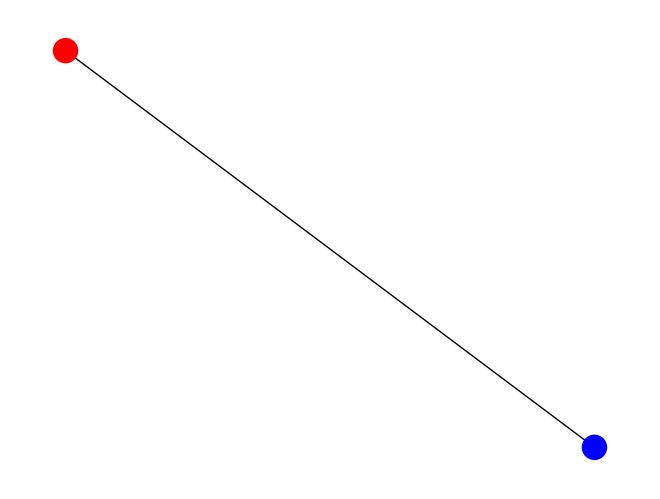

In [3]:
# GRAPH VISUALIZATION
G = nx.Graph()              # Create a graph
G.add_edges_from(edges)     # Add edges to the graph
# Assign colors to nodes
ncolors = len(colors)
node_colors = [colors[i % ncolors] for i in range(nvertices)]
# Plot the graph
nx.draw(G, with_labels=False, node_color=node_colors)
plt.show()

In [4]:

# BRUTE FORCE TO SOLVE GCP
nqubits = nvertices * ncolors

# Initial state
initial_state = np.ones(2**nqubits) / np.sqrt(2**nqubits)

# Number of gs vectors
ngs = 0
# Create the vector to embed the gs
gs_vectors = []
for comp_basis in range(2 ** nqubits):
    bitstring = "{0:0{nbits}b}".format(comp_basis, nbits=nqubits)
    bits = list(map(int, [*bitstring]))
    # Cost function
    # First term to ensure that only one color is assigned to every vertex
    cost_fun = sum(
        (1 - sum(bits[i * nvertices + v] for i in range(ncolors))) ** 2
        for v in range(nvertices)
    )

    # Second term to ensure that no two adjacent vertices have the same color
    cost_fun += (sum(sum(bits[i * nvertices + e[0]] * bits[i * nvertices + e[1]] for i in range(ncolors)) for e in edges))

    solution = False
    if cost_fun == 0:
        ngs += 1
        solution = True
        # Create the vector to embed the gs
        vec = np.zeros(2 ** nqubits, dtype=np.complex128)
        vec[comp_basis] = 1. + 0.j
        # Add the gs vector solution
        gs_vectors.append(vec)
        print(f"{bitstring} is a {solution} solution.\n")

def bitfield(n, L):
    result = np.binary_repr(n, L)
    return [int(digit) for digit in result]  # [2:] to chop off the "0b" part


0110 is a True solution.

1001 is a True solution.



In [5]:
# QAOA EXECUTION

def get_operator(edges, num_nodes, num_colors):
    """Generate Hamiltonian for the graph coloring problem.

    Args:
        edges: List of edges.
        num_nodes: Number of nodes.
        num_colors: Number of colors.

    Returns:
        Operator for the Hamiltonian
        A constant shift for the obj function.
    """
    pauli_list = []
    coeffs = []
    shift = 0

    # Constraint that each node has exactly one color
    for i in range(num_nodes):
        for color in range(num_colors):
            x_p = np.zeros(num_nodes * num_colors, dtype=bool)
            z_p = np.zeros(num_nodes * num_colors, dtype=bool)
            z_p[i * num_colors + color] = True
            pauli_list.append(Pauli((z_p, x_p)))
            coeffs.append(-1)
            shift += 1

        for color1 in range(num_colors):
            for color2 in range(color1 + 1, num_colors):
                x_p = np.zeros(num_nodes * num_colors, dtype=bool)
                z_p = np.zeros(num_nodes * num_colors, dtype=bool)
                z_p[i * num_colors + color1] = True
                z_p[i * num_colors + color2] = True
                pauli_list.append(Pauli((z_p, x_p)))
                coeffs.append(2)

    # Constraint that adjacent nodes have different colors
    for i, j in edges:
        for color in range(num_colors):
            x_p = np.zeros(num_nodes * num_colors, dtype=bool)
            z_p = np.zeros(num_nodes * num_colors, dtype=bool)
            z_p[i * num_colors + color] = True
            z_p[j * num_colors + color] = True
            pauli_list.append(Pauli((z_p, x_p)))
            coeffs.append(1)

    return SparsePauliOp(pauli_list, coeffs=coeffs), shift

qubit_op, offset = get_operator(edges, nvertices, ncolors)

In [6]:

sampler = Sampler()

def sample_most_likely(state_vector):
    """Compute the most likely binary string from state vector.
    Args:
        state_vector: State vector or quasi-distribution.

    Returns:
        Binary string as an array of ints.
    """
    if isinstance(state_vector, QuasiDistribution):
        values = list(state_vector.values())
    else:
        values = state_vector
    n = int(np.log2(len(values)))
    k = np.argmax(np.abs(values))
    x = bitfield(k, n)
    x.reverse()
    return np.asarray(x)

algorithm_globals.random_seed = 10598

optimizer = COBYLA()
qaoa = QAOA(sampler, optimizer, reps=2)

result = qaoa.compute_minimum_eigenvalue(qubit_op)

x = sample_most_likely(result.eigenstate)

print(x)
#print(f'Objective value computed by QAOA is {objective_value(x, w)}')

[0 1 1 0]
